# Import libraries

In [ ]:
import os
import random
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F

import torchvision
import torchvision.transforms as transforms

# Set random seed for reproducibility
manualSeed = 999
#manualSeed = random.randint(1, 10000) # use if you want new results
print("Random Seed: ", manualSeed)
random.seed(manualSeed)
torch.manual_seed(manualSeed)

Random Seed:  999


# Input

In [ ]:
# Root directory for dataset
dataroot = '/data'

# Number of workers for dataloader
workers = 2

# Batch size during training
batch_size = 32

# Spatial size of training images. All images will be resized to this
#   size using a transformer.
image_size = 28

# Number of channels in the training images. For color images this is 3
nc = 1

# Size of z latent vector (i.e. size of generator input)
nz = 100

# Size of feature maps in generator
ngf = 64

# Size of feature maps in discriminator
ndf = 64

# Number of training epochs
num_epochs = 5

# Learning rate for optimizers
lr = 1e-4

# Beta1 hyperparam for Adam optimizers
beta1 = 0.5

# Number of GPUs available. Use 0 for CPU mode.
ngpu = 1

# Prepare data

In [ ]:
# We can use an image folder dataset the way we have it setup.
# Create the dataset
train_set = torchvision.datasets.MNIST(
    root = dataroot, # the location on disk where the data is located.
    train=True, # if the dataset is the training set.
    download=True, # if the data should be downloaded.
    transform=transforms.Compose([
      transforms.Resize(image_size),
      transforms.ToTensor(),
      transforms.Normalize((0.5,), (0.5,)),
    ]) # A composition of transformations that should be performed on the dataset elements.
)

# Create the dataloader
dataloader = torch.utils.data.DataLoader(train_set, batch_size=batch_size,
                                         shuffle=True, num_workers=workers)

# Decide which device we want to run on
device = torch.device("cuda:0" if (torch.cuda.is_available() and ngpu > 0) else "cpu")

  0%|          | 0/9912422 [00:00<?, ?it/s]

Extracting /data/MNIST/raw/train-images-idx3-ubyte.gz to /data/MNIST/raw



  0%|          | 0/28881 [00:00<?, ?it/s]

Extracting /data/MNIST/raw/train-labels-idx1-ubyte.gz to /data/MNIST/raw



  0%|          | 0/1648877 [00:00<?, ?it/s]

Extracting /data/MNIST/raw/t10k-images-idx3-ubyte.gz to /data/MNIST/raw



  0%|          | 0/4542 [00:00<?, ?it/s]

Extracting /data/MNIST/raw/t10k-labels-idx1-ubyte.gz to /data/MNIST/raw



/usr/local/lib/python3.7/dist-packages/torchvision/datasets/mnist.py:498: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  /pytorch/torch/csrc/utils/tensor_numpy.cpp:180.)
  return torch.from_numpy(parsed.astype(m[2], copy=False)).view(*s)


In [ ]:
print(train_set)
print(train_set.data.size())
print(train_set.targets.size())

Dataset MNIST
    Number of datapoints: 60000
    Root location: /data
    Split: Train
    StandardTransform
Transform: Compose(
               Resize(size=28, interpolation=bilinear, max_size=None, antialias=None)
               ToTensor()
               Normalize(mean=(0.5,), std=(0.5,))
           )
torch.Size([60000, 28, 28])
torch.Size([60000])


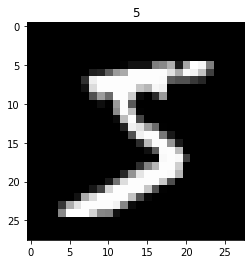

In [ ]:
# Visualization of MNIST dataset

import matplotlib.pyplot as plt

plt.imshow(train_set.data[0], cmap='gray')
plt.title('%i' % train_set.targets[0])
plt.show()


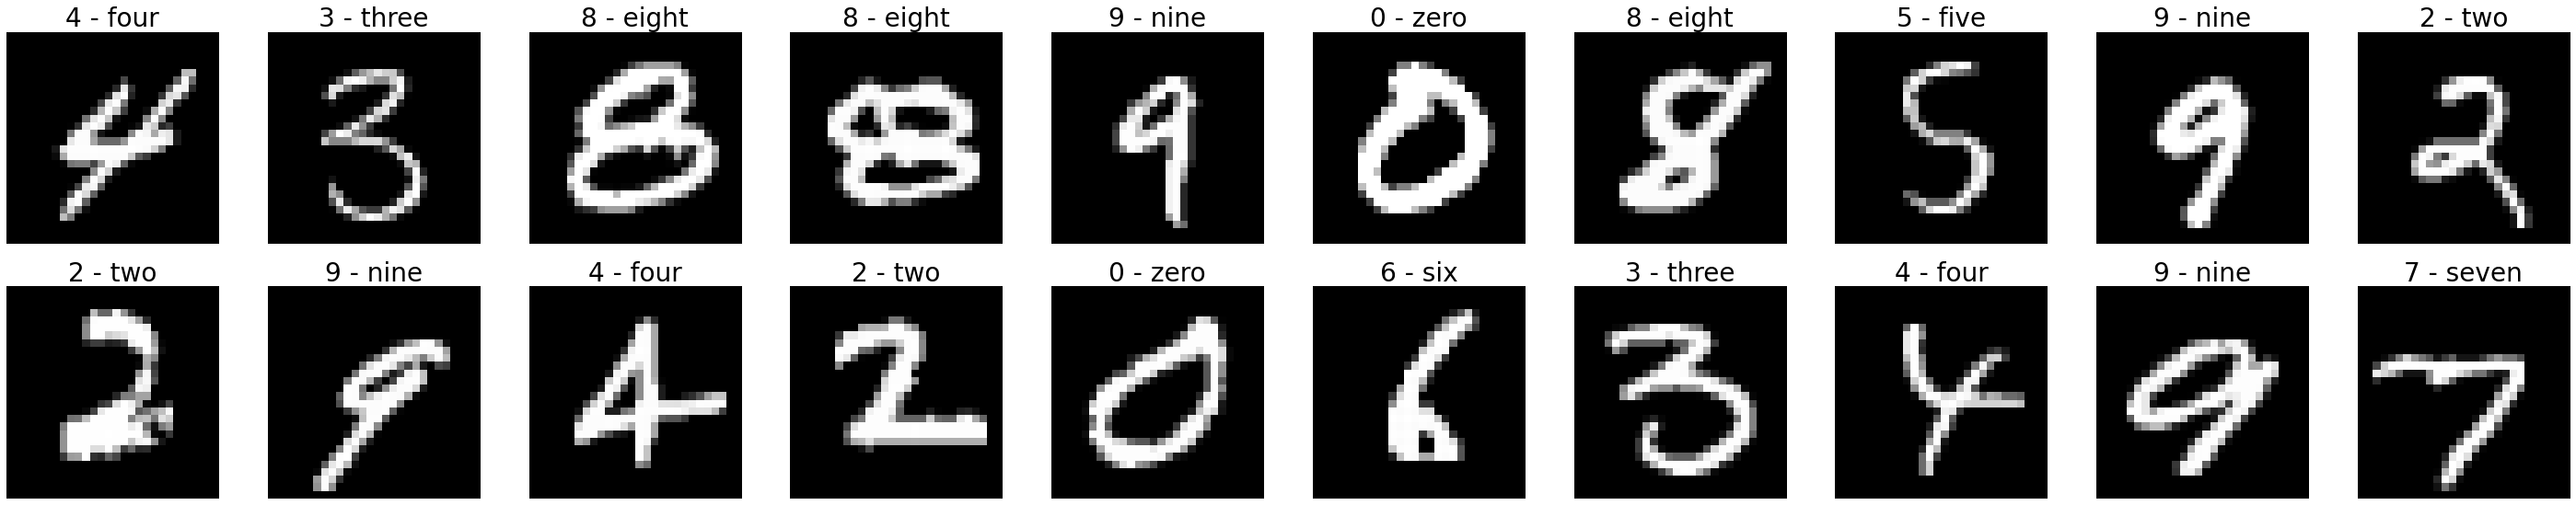

In [ ]:
# Plot multiple train data

how_many_to_plot = 20

train_loader = torch.utils.data.DataLoader(
    train_set, batch_size=1, shuffle=True
)

plt.figure(figsize=(50,50))
for i, batch in enumerate(train_loader, start=1):
    image, label = batch
    plt.subplot(10,10,i)
    plt.imshow(image.reshape(28,28), cmap='gray')
    plt.axis('off')
    plt.title(train_set.classes[label.item()], fontsize=28)
    if (i >= how_many_to_plot): break
plt.show()

# Build model

In [ ]:
import torch.nn as nn
import torch.nn.functional as F

# custom weights initialization called on netG and netD
def weights_init(m):
    classname = m.__class__.__name__
    if classname.find('Conv') != -1:
        m.weight.data.normal_(0.0, 0.02)
    elif classname.find('BatchNorm') != -1:
        m.weight.data.normal_(1.0, 0.02)
        m.bias.data.fill_(0)

class Generator(nn.Module):
    """
    input (N, 100)
    output (N, 1, 28, 28)
    """
    def __init__(self, ngpu):
        super(Generator, self).__init__()
        self.ngpu = ngpu
        self.main = nn.Sequential(
            # input is Z, going into a convolution
            nn.ConvTranspose2d(nz, ngf * 8, 3, 1, 0, bias=False),
            nn.BatchNorm2d(ngf * 8),
            nn.ReLU(True),
            # state size. (ngf*8) x 4 x 4
            nn.ConvTranspose2d(ngf * 8, ngf * 4, 3, 2, 1, bias=False),
            nn.BatchNorm2d(ngf * 4),
            nn.ReLU(True),
            # state size. (ngf*4) x 8 x 8
            nn.ConvTranspose2d(ngf * 4, ngf * 2, 2, 2, 1, bias=False),
            nn.BatchNorm2d(ngf * 2),
            nn.ReLU(True),
            # state size. (ngf*2) x 16 x 16
            nn.ConvTranspose2d(ngf * 2, ngf, 3, 2, 1, bias=False),
            nn.BatchNorm2d(ngf),
            nn.ReLU(True),
            # state size. (ngf) x 32 x 32
            nn.ConvTranspose2d(ngf, nc, 2, 2, 1, bias=False),
            nn.Tanh()
            # state size. (nc) x 64 x 64
        )

    def forward(self, input):
        return self.main(input)

class Discriminator(nn.Module):
    """
    input (N, 1, 28, 28)
    output (N, )
    kernel_size=(3, 3)
    """
    def __init__(self, ngpu):
        super(Discriminator, self).__init__()
        self.ngpu = ngpu
        self.main = nn.Sequential(
            # input is (nc) x 64 x 64
            nn.Conv2d(nc, ndf, 2, 2, 1, bias=False),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. (ndf) x 32 x 32
            nn.Conv2d(ndf, ndf * 2, 3, 2, 1, bias=False),
            nn.BatchNorm2d(ndf * 2),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. (ndf*2) x 16 x 16
            nn.Conv2d(ndf * 2, ndf * 4, 2, 2, 1, bias=False),
            nn.BatchNorm2d(ndf * 4),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. (ndf*4) x 8 x 8
            nn.Conv2d(ndf * 4, ndf * 8, 3, 2, 1, bias=False),
            nn.BatchNorm2d(ndf * 8),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. (ndf*8) x 4 x 4
            nn.Conv2d(ndf * 8, 1, 3, 1, 0, bias=False),
            # nn.Sigmoid()
        )

    def forward(self, input):
        return self.main(input).view(-1)    

# Train model

In [ ]:
from torch.utils.data import Dataset, DataLoader
from torch import optim

# Create the model
netG = Generator(ngpu).to(device)
netD = Discriminator(ngpu).to(device)
netG.train()
netD.train()

# Handle multi-gpu if desired
if (device.type == 'cuda') and (ngpu > 1):
    netG = nn.DataParallel(netG, list(range(ngpu)))
    netD = nn.DataParallel(netD, list(range(ngpu)))

# Apply the weights_init function to randomly initialize all weights
#  to mean=0, stdev=0.02.
netG.apply(weights_init)
netD.apply(weights_init)

# Print the model
print(netG)
print(netD)

# loss criterion
criterion = nn.BCEWithLogitsLoss() # nn.BCELoss()
# input of BCELoss should be between 0 and 1
# optimizer
opt_D = torch.optim.Adam(netD.parameters(), lr=lr, betas=(beta1, 0.999))
opt_G = torch.optim.Adam(netG.parameters(), lr=lr, betas=(beta1, 0.999))

Generator(
  (main): Sequential(
    (0): ConvTranspose2d(100, 512, kernel_size=(3, 3), stride=(1, 1), bias=False)
    (1): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): ConvTranspose2d(512, 256, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
    (4): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU(inplace=True)
    (6): ConvTranspose2d(256, 128, kernel_size=(2, 2), stride=(2, 2), padding=(1, 1), bias=False)
    (7): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (8): ReLU(inplace=True)
    (9): ConvTranspose2d(128, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
    (10): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (11): ReLU(inplace=True)
    (12): ConvTranspose2d(64, 1, kernel_size=(2, 2), stride=(2, 2), padding=(1, 1), bias=False)
    (13): Tanh()
  )
)


Starting Training Loop...
Epoch [1/5] 1875/1875                 Loss_D: 0.0608 Loss_G: 2.2301

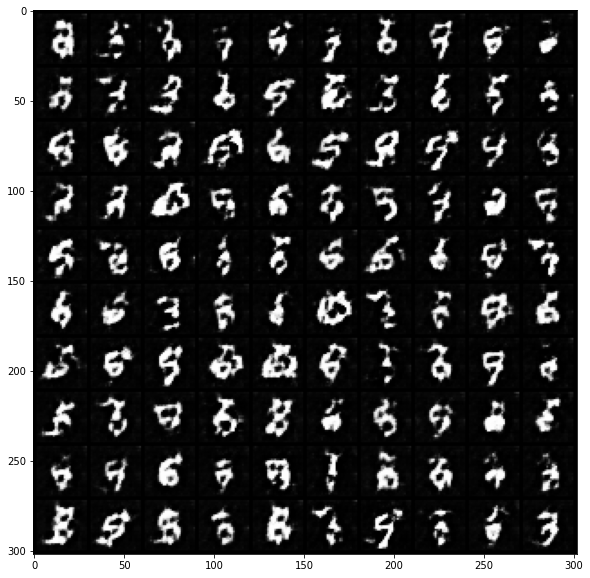

Epoch [2/5] 1875/1875                 Loss_D: 0.1280 Loss_G: 2.4351

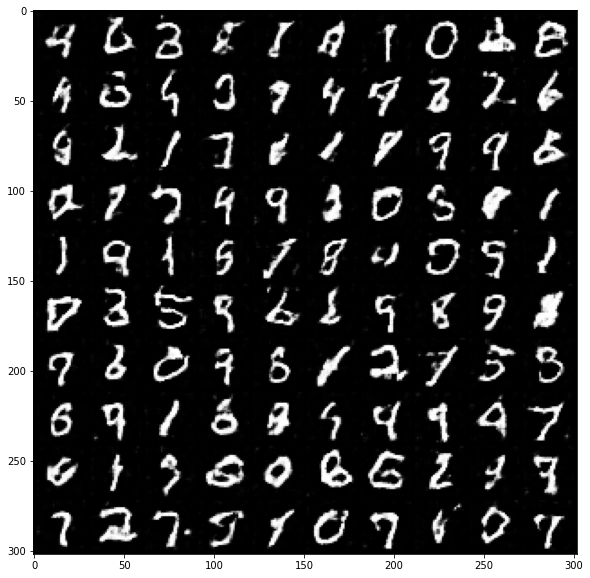

Epoch [3/5] 1875/1875                 Loss_D: 0.0589 Loss_G: 4.7742

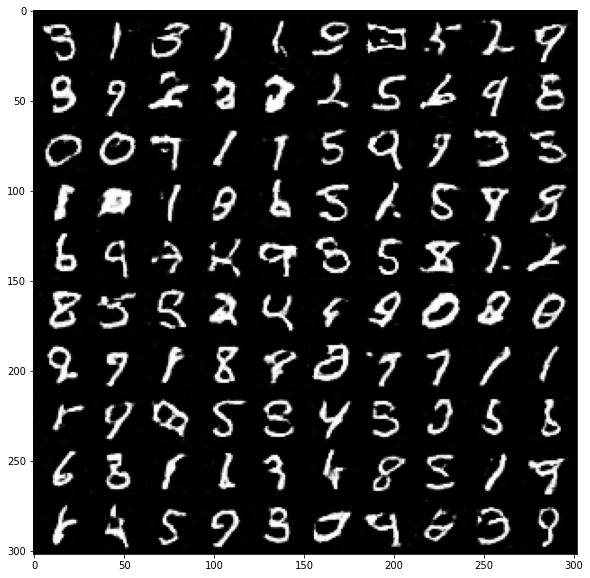

Epoch [4/5] 1875/1875                 Loss_D: 0.3692 Loss_G: 2.2156

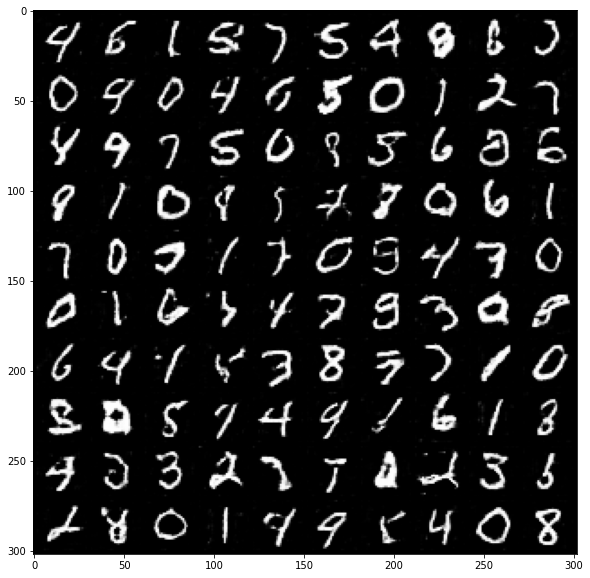

Epoch [5/5] 1875/1875                 Loss_D: 0.2354 Loss_G: 3.3752

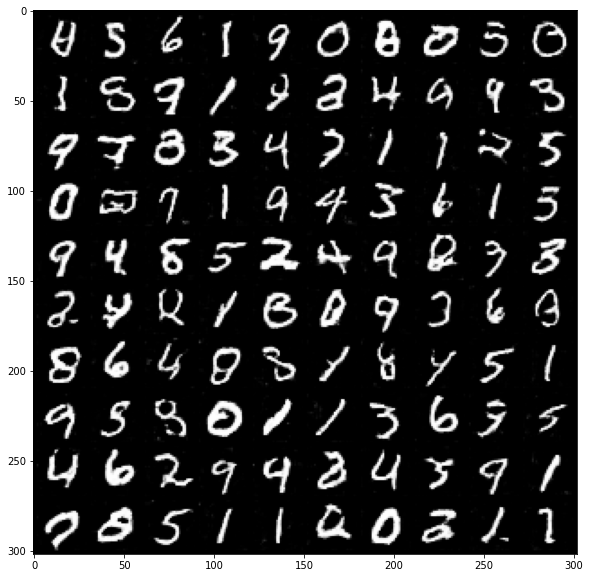

In [ ]:
import sys
# Training Loop

# Lists to keep track of progress
img_list = []
G_losses = []
D_losses = []
nsample = 100

print("Starting Training Loop...")
# For each epoch
for e, epoch in enumerate(range(num_epochs)):
    # For each batch in the dataloader
    for i, data in enumerate(dataloader):
        # format batch, data[0]: image, data[1]: label
        real_cpu = data[0].to(device)
        b_size = real_cpu.size(0)

        """ Train netD """
        noise = torch.randn(b_size, nz, 1, 1, device=device)
        r_imgs = real_cpu
        f_imgs = netG(noise)

        # label        
        r_label = torch.ones((b_size)).to(device)
        f_label = torch.zeros((b_size)).to(device)

        # dis
        r_logit = netD(r_imgs.detach())
        f_logit = netD(f_imgs.detach())
            
        # compute loss
        r_loss = criterion(r_logit, r_label)
        f_loss = criterion(f_logit, f_label)
        loss_D = (r_loss + f_loss) / 2

        # update model
        netD.zero_grad()
        loss_D.backward()
        opt_D.step()

        """ Train netG """
        # leaf
        z = torch.randn(b_size, nz, 1, 1, device=device)
        f_imgs = netG(z)   

        # dis
        f_logit = netD(f_imgs)

        # compute loss
        loss_G = criterion(f_logit, r_label)

        # update model
        netG.zero_grad()
        loss_G.backward()
        opt_G.step() 

        # log
        print(f'\rEpoch [{epoch+1}/{num_epochs}] {i+1}/{len(dataloader)} \
                Loss_D: {loss_D.item():.4f} Loss_G: {loss_G.item():.4f}', end='')
    
    # finish a epoch
    # Save Losses for plotting later
    G_losses.append(loss_G.item())
    D_losses.append(loss_D.item())

    # Check how the generator is doing
    netG.eval()
    z_sample = torch.randn(nsample, nz, 1, 1, device=device)
    f_imgs_sample = (netG(z_sample).data + 1) / 2.0
    # show generated image
    grid_img = torchvision.utils.make_grid(f_imgs_sample.cpu(), nrow=10)
    plt.figure(figsize=(10,10))
    plt.imshow(grid_img.permute(1, 2, 0))
    plt.show()
    netG.train()

# Analyze results

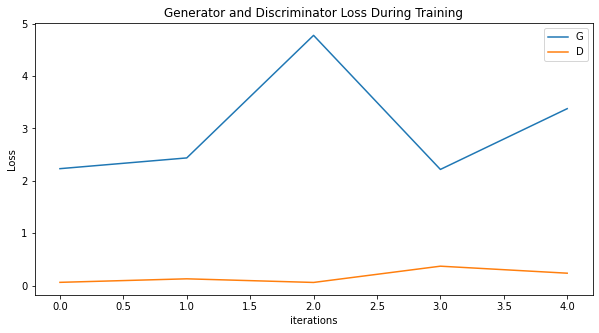

In [ ]:
plt.figure(figsize=(10,5))
plt.title("Generator and Discriminator Loss During Training")
plt.plot(G_losses, label="G")
plt.plot(D_losses, label="D")
plt.xlabel("iterations")
plt.ylabel("Loss")
plt.legend()
plt.show()

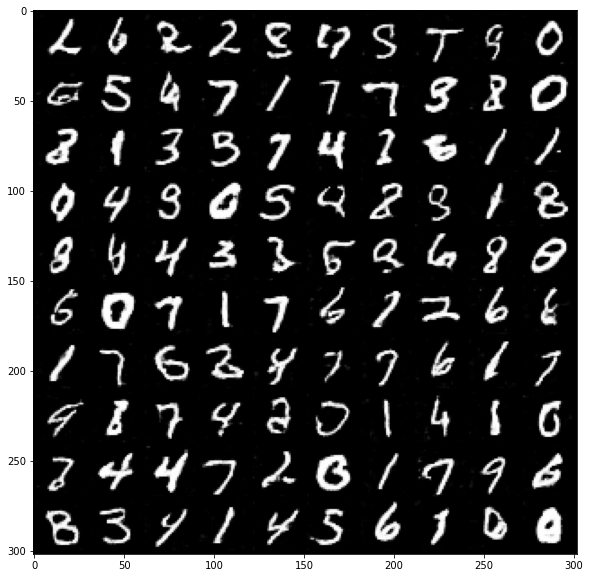

In [ ]:
# generate images and save the result
n_output = 20
z_sample = torch.randn(nsample, nz, 1, 1, device=device)
imgs_sample = (netG(z_sample).data + 1) / 2.0

# show image
grid_img = torchvision.utils.make_grid(imgs_sample.cpu(), nrow=10)
plt.figure(figsize=(10,10))
plt.imshow(grid_img.permute(1, 2, 0))
plt.show()